# WEEKLY PROJECT - FACE RECOGNITION #

Week 9 - Hà, Jenny, Hương, Huyền, Cường, Quyên


### 1 - Understanding YOLO_face ###

In [ ]:
MODEL = '/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Saved_model/Yolo_Face/yolov3-face.cfg'
WEIGHT = '/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Saved_model/Yolo_Face/yolov3-wider_16000.weights'

net = cv2.dnn.readNetFromDarknet(MODEL, WEIGHT)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [ ]:
from google.colab.patches import cv2_imshow
img_path = '/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Test/test_hinh_nhom_1.png'
frame = cv2.imread(img_path)
cv2_imshow(frame)

In [ ]:
IMG_WIDTH, IMG_HEIGHT = 416, 416

# Making blob object from original image, expand dim and sthg with mean: READUP
blob = cv2.dnn.blobFromImage(frame, 1/255, (IMG_WIDTH, IMG_HEIGHT),
                             [0, 0, 0], 1, crop=False)
blob.shape

(1, 3, 416, 416)

In [ ]:
# Set model input, to set the input data into the model
net.setInput(blob) 
net

<dnn_Net 0x7f791822e470>

In [ ]:
# Define the layers that we want to get the outputs from. returns all the output layers' name
output_layers = net.getUnconnectedOutLayersNames()
output_layers

['yolo_82', 'yolo_94', 'yolo_106']

In [ ]:
# Run 'prediction'. net.forward(_) to pass data through the model (similar to fit and predict in sklearn)
outs = net.forward(output_layers) 
len(outs)

3

In [ ]:
outs[0].shape

(507, 6)

In [ ]:
outs[1].shape

(2028, 6)

In [ ]:
outs[2].shape

(8112, 6)

(1248, 416)


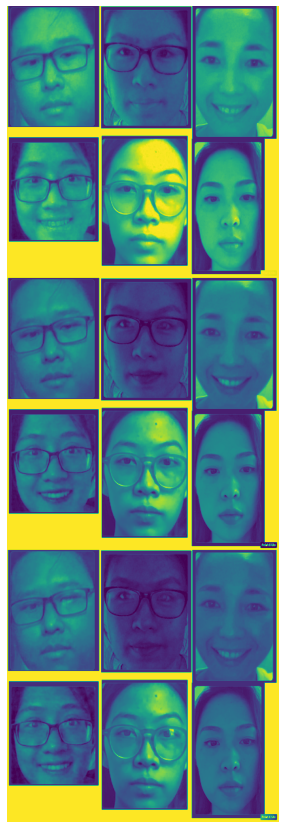

In [ ]:
# TIP: The blob result will have the shape of (1, 3, IMG_WIDTH, IMG_HEIGHT). In order to view it, use the below code snippet.  
blobb = blob.reshape(blob.shape[2] * blob.shape[1], blob.shape[3]) 
print(blobb.shape)

plt.figure(figsize=(15, 15))
plt.imshow(blobb)
plt.axis('off')
plt.show()

In [ ]:
frame.shape

(1148, 1322, 3)

In [ ]:
frame_height = frame.shape[0]
frame_width = frame.shape[1]

# Scan through all the bounding boxes output from the network and keep only
# the ones with high confidence scores. Assign the box's class label as the
# class with the highest score.

confidences = []
boxes = []

# Each frame produces 3 outs corresponding to 3 output layers
for out in outs:
		# One out has multiple predictions for multiple captured objects.
    for detection in out:
        confidence = detection[-1]
		# Extract position data of face area (only area with high confidence)
        if confidence > 0.5:
            center_x = int(detection[0] * frame_width)
            center_y = int(detection[1] * frame_height)
            width = int(detection[2] * frame_width)
            height = int(detection[3] * frame_height)
            
			# Find the top left point of the bounding box 
            topleft_x = int(center_x - width/2) 
            topleft_y = int(center_y - height/2)
            confidences.append(float(confidence))
            boxes.append([topleft_x, topleft_y, width, height])

# Perform non-maximum suppression to eliminate 
# redundant overlapping boxes with lower confidences.
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
indices

array([[4],
       [0],
       [2],
       [1],
       [5],
       [3]], dtype=int32)

In [ ]:
confidences

[0.9993487596511841,
 0.9983025193214417,
 0.9988561272621155,
 0.9980088472366333,
 0.9998123645782471,
 0.9981966614723206,
 0.9600057005882263]

In [ ]:
boxes

[[30, -2, 375, 512],
 [476, 18, 408, 469],
 [922, 26, 334, 556],
 [44, 533, 353, 472],
 [499, 592, 359, 488],
 [935, 564, 291, 578],
 [952, 612, 247, 485]]

In [ ]:
result = frame.copy()
final_boxes = []
for i in indices:
    i = i[0]
    box = boxes[i]
    final_boxes.append(box)

    # Extract position data
    left = box[0]
    top = box[1]
    width = box[2]
    height = box[3]

    # Draw bouding box with the above measurements
    ### YOUR CODE HERE
    a = 10
    cv2.rectangle(result, (left - a,top - a), (((left+width) + 2*a), ((top+height)+ 2*a)), (0, 255, 0), 2)
		
		# Display text about confidence rate above each box
    text_confidence_rate = f'{confidences[i]:.2f}'
    ### YOUR CODE HERE
    cv2.putText(result,text_confidence_rate, (left-2-a, top-2-a), cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0,0,255), 2)

# Display text about number of detected faces on topleft corner
# YOUR CODE HERE
text_total_face = f'Number of face(s) detected: {len(final_boxes)}'
print(text_total_face)
cv2.putText(result, text_total_face, (15,30), cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0,0,255), 2)

cv2_imshow(result)
#cv2_imshow(result)

## 2 - Data Preprocess for Classification Training ##

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
import keras
import pathlib
import glob
import cv2

In [ ]:
cv2.imread('/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Cropped_face/Jenny/Jenny182902.jpg').shape

(319, 280, 3)

In [ ]:
#Create directories 
dataset = pathlib.Path('/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Cropped_face')
data_classes = list(dataset.glob('*'))
data_classes

[PosixPath('/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Cropped_face/Quyen'),
 PosixPath('/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Cropped_face/Ha'),
 PosixPath('/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Cropped_face/Jenny'),
 PosixPath('/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Cropped_face/Huong'),
 PosixPath('/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Cropped_face/Huyen'),
 PosixPath('/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Cropped_face/Cuong')]

In [ ]:
import PIL
from PIL import UnidentifiedImageError

# Check for unreadable images:

format = ['*.jpg', '*.png', '*.jpeg']
for i in format: 
  path = dataset.rglob(i)
  for p in path:
    try:
      img = PIL.Image.open(p)
    except PIL.UnidentifiedImageError:
      print(p)

In [ ]:
# Using keras preprocess without augment as data are images taken with required conditions mimic testing enviroment
train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset,
                                                               label_mode = 'int',
                                                                validation_split=0.2,
                                                                subset="training",
                                                                image_size=(224, 224),
                                                                seed = 27,
                                                                shuffle=True,
                                                                batch_size=30)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset,
                                                             label_mode = 'int',
                                                              validation_split=0.2,
                                                              subset="validation",
                                                              image_size=(224, 224),
                                                              shuffle=True,
                                                              seed = 27,
                                                              batch_size=30)


Found 2310 files belonging to 6 classes.
Using 1848 files for training.
Found 2310 files belonging to 6 classes.
Using 462 files for validation.


In [ ]:
train_ds.class_names
val_ds.class_names
# thứ tự các label để predict

['Cuong', 'Ha', 'Huong', 'Huyen', 'Jenny', 'Quyen']

## 3 - Train Model ###

In [ ]:
# Try MobilenetV2 for its light size/high accuracy versus other models

base_model = tf.keras.applications.MobileNetV2(weights = 'imagenet',
                                              input_shape = (224,224,3),
                                              include_top = False)

len(base_model.layers)




154

In [ ]:
from keras.applications.mobilenet_v2 import preprocess_input
import keras
def model_maker():
  # Preprocess_input
  inputs = keras.Input(shape = (224, 224, 3))
  x = keras.applications.mobilenet_v2.preprocess_input(inputs)
  x = base_model(x, training = False) # IMPORTANT: training = false to always lock the model's inference mode 
                                        # on batch normalization, even later some layers are opened for fine tuning
  x = keras.layers.GlobalAveragePooling2D()(x)
  # x = keras.layers.Dropout(0.2)(x)
  outputs = keras.layers.Dense(6, activation = 'softmax')(x)
  model = keras.Model(inputs, outputs)  
  return model

In [ ]:
model = model_maker()
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                  min_delta = 0.0005,
                                                  patience = 15,
                                                  restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                  factor = 0.3,
                                                  patience = 5,
                                                  min_delta = 0.001,
                                                  verbose = 1)

saved_model = pathlib.Path('/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Saved_model')

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = saved_model/'WP10_Face_Recognition_model.h5',
                                                  save_weights_only = False,
                                                  save_best_only = True,
                                                  monitor = 'val_loss') # see at the end if restore is needed
                                                
# YOUR CALLBACKS
callbacks = [early_stopping, reduce_lr, checkpoint]


In [ ]:
base_model.trainable = True

for layer in base_model.layers[:150]:
  layer.trainable = False

model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [ ]:
model.compile(optimizer = 'adam',
               loss = 'sparse_categorical_crossentropy',
               metrics = 'acc')

In [ ]:
# Fit many time with different random seed at image_dataset_from_directory (see above), model.complie for every fit to reset learning rate

history_1 = model.fit(train_ds,
                      validation_data = val_ds,
                      epochs = 30,
                      callbacks = callbacks)

Epoch 1/30
62/62 [==============================] - 7s 110ms/step - loss: 4.1949e-04 - acc: 1.0000 - val_loss: 2.3075e-04 - val_acc: 1.0000 - lr: 8.1000e-06
Epoch 2/30
62/62 [==============================] - 7s 100ms/step - loss: 2.7049e-04 - acc: 1.0000 - val_loss: 2.1413e-04 - val_acc: 1.0000 - lr: 8.1000e-06
Epoch 3/30
62/62 [==============================] - 7s 105ms/step - loss: 2.0086e-04 - acc: 1.0000 - val_loss: 2.0166e-04 - val_acc: 1.0000 - lr: 8.1000e-06
Epoch 4/30
62/62 [==============================] - 7s 101ms/step - loss: 1.7100e-04 - acc: 1.0000 - val_loss: 1.9247e-04 - val_acc: 1.0000 - lr: 8.1000e-06
Epoch 5/30
62/62 [==============================] - 7s 100ms/step - loss: 1.4959e-04 - acc: 1.0000 - val_loss: 1.8628e-04 - val_acc: 1.0000 - lr: 8.1000e-06
Epoch 6/30
62/62 [==============================] - ETA: 0s - loss: 1.3347e-04 - acc: 1.0000
Epoch 00006: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.
62/62 [==============================] - 7

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Saved_model/WP10_Face_Recognition_model.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [ ]:
predictions = model.predict(val_ds)
predictions

array([[2.3920634e-07, 2.2302268e-07, 9.9999619e-01, 6.6909649e-07,
        9.1078465e-07, 1.7373771e-06],
       [4.6668871e-04, 7.7396699e-08, 2.0624245e-07, 5.2883558e-04,
        9.9900419e-01, 3.6394027e-08],
       [9.9999249e-01, 1.1854382e-06, 8.1551363e-08, 6.5968317e-07,
        5.6253352e-06, 1.2095100e-09],
       ...,
       [4.6588278e-07, 9.3575733e-07, 9.1732382e-09, 9.8501450e-01,
        1.4983744e-02, 3.8224067e-07],
       [1.2830571e-08, 1.7215177e-08, 9.9996305e-01, 1.6971959e-06,
        3.0639323e-05, 4.6857776e-06],
       [1.0778442e-07, 7.2699529e-04, 8.6459168e-06, 4.5687919e-08,
        1.4183068e-07, 9.9926406e-01]], dtype=float32)

In [ ]:
pred_indices = np.argmax(predictions, axis = 1) # lấy tên cột chíh
pred_indices

array([2, 4, 0, 3, 4, 3, 2, 3, 1, 0, 3, 1, 4, 2, 5, 4, 2, 3, 2, 0, 5, 3,
       4, 3, 3, 2, 2, 3, 4, 2, 3, 3, 5, 2, 3, 5, 4, 5, 3, 4, 3, 1, 3, 5,
       4, 2, 3, 3, 2, 2, 5, 3, 3, 4, 5, 3, 5, 1, 2, 5, 5, 0, 3, 3, 0, 0,
       5, 2, 3, 4, 2, 5, 4, 3, 1, 4, 4, 2, 0, 0, 1, 4, 2, 1, 2, 3, 2, 0,
       2, 4, 5, 3, 3, 2, 2, 1, 5, 3, 3, 2, 5, 2, 4, 4, 5, 1, 3, 1, 1, 5,
       0, 2, 4, 3, 1, 2, 4, 3, 3, 0, 4, 1, 2, 0, 4, 4, 5, 3, 4, 5, 4, 5,
       5, 4, 0, 1, 3, 2, 1, 5, 5, 4, 4, 4, 3, 3, 4, 1, 0, 3, 5, 2, 2, 4,
       2, 1, 0, 0, 3, 3, 2, 0, 5, 4, 1, 5, 2, 4, 1, 0, 2, 4, 4, 5, 4, 1,
       2, 5, 3, 3, 2, 4, 4, 2, 1, 5, 5, 5, 2, 3, 2, 4, 4, 0, 2, 2, 5, 3,
       1, 3, 5, 5, 5, 5, 2, 3, 5, 4, 3, 5, 5, 5, 0, 1, 2, 3, 2, 5, 5, 3,
       4, 3, 3, 4, 2, 0, 4, 2, 3, 3, 1, 1, 4, 5, 2, 3, 4, 4, 4, 4, 4, 2,
       3, 4, 4, 0, 4, 4, 4, 5, 3, 5, 3, 4, 2, 2, 3, 1, 2, 0, 2, 5, 5, 3,
       2, 3, 0, 2, 3, 3, 4, 4, 3, 2, 1, 3, 2, 0, 3, 1, 1, 1, 3, 5, 2, 5,
       1, 2, 5, 3, 4, 5, 2, 4, 3, 2, 0, 4, 3, 2, 4,

In [ ]:
class_indices = {}
for i, name in enumerate(val_ds.class_names):
  class_indices[name] = i

class_indices # dictionary ko iterate được --> chuyển thành dạng list để iterate .items()

{'Cuong': 0, 'Hakul': 1, 'Huong': 2, 'Huyen': 3, 'Jenny': 4, 'Quyen': 5}

In [ ]:
class_indices.items()

dict_items([('Cuong', 0), ('Hakul', 1), ('Huong', 2), ('Huyen', 3), ('Jenny', 4), ('Quyen', 5)])

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt


# uploaded = files.upload()
# for fn in uploaded.keys():
#   img_path = './' + fn


def predict(model, image_path, img_size):
  img = image.load_img(image_path, target_size = (img_size, img_size))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis = 0) # expand dims vì model nhận batch (4 dimensions: 3 chièu ảnh, 1 chiều qty/batch)
  prediction = model.predict(img)

  for key, value in class_indices.items():
    if value == prediction[0].argmax():
      pred = key
  
  plt.figure(figsize=(9, 6))
  img = mpimg.imread(image_path)
  imgplot = plt.imshow(img)
  plt.title('Prediction: ' + pred.upper())
  plt.grid(b=None)
  plt.axis('off')
  plt.show()

  return True



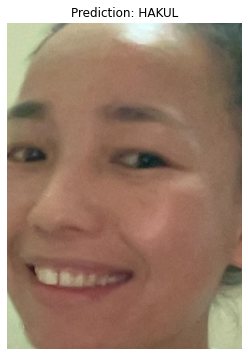

True

In [ ]:
img_path = '/content/gdrive/MyDrive/Cropped_image/Hakul/processed_hale105.jpeg'
predict(model, img_path , 128)

In [ ]:
img_path = '/content/gdrive/MyDrive/Cropped_image/Hakul/processed_hale105.jpeg'
predict(model, img_path , 128)

## Using KFold ##

In [ ]:
#Create directories 
dataset = pathlib.Path('/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Cropped_face')
data_classes = list(dataset.glob('*'))
img_paths = list(dataset.glob('*/*'))
img_paths = [str(path) for path in img_paths]
img_paths[1]

'/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Cropped_face/Quyen/215338.jpeg'

In [ ]:
all_labels = list(map(lambda x: x.split('/')[-2], img_paths))
all_labels[:10]

['Quyen',
 'Quyen',
 'Quyen',
 'Quyen',
 'Quyen',
 'Quyen',
 'Quyen',
 'Quyen',
 'Quyen',
 'Quyen']

In [ ]:
list(dataset.glob('*'))[0].name

'Quyen'

In [ ]:
labels = sorted(item.name for item in dataset.glob('*/') if item.is_dir())
labels

['Cuong', 'Ha', 'Huong', 'Huyen', 'Jenny', 'Quyen']

In [ ]:
label_index = dict((name, index) for index, name in enumerate(labels))
label_index

{'Cuong': 0, 'Ha': 1, 'Huong': 2, 'Huyen': 3, 'Jenny': 4, 'Quyen': 5}

In [ ]:
all_image_labels = [label_index[label] for label in all_labels] # lấy số index của label cho từng hình 
all_image_labels[:10]

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

In [ ]:
print(img_paths[:10])
print(all_image_labels[:10])

['/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Cropped_face/Huong/processed_opencv_frame_49.jpeg', '/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Cropped_face/Huong/huong_194832.jpeg', '/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Cropped_face/Huong/huong_194023.jpeg', '/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Cropped_face/Huong/processed_opencv_frame_45.jpeg', '/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Cropped_face/Huong/processed_opencv_frame_53.jpeg', '/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Cropped_face/Huong/processed_opencv_frame_150.jpeg', '/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Cropped_face/Huong/processed_opencv_frame_146.jpeg', '/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Cropped_face/Huong/huong_194957.jpeg', '/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Cropped_face/Huong/huong_194941.jpeg', '/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Cropped_face/Huong/processed_opencv_frame_32.jpeg']
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [ ]:
def preprocess_image(path):
  img_read = tf.io.read_file(path)
  image = tf.image.decode_jpeg(img_read, channels = 3)
  image = tf.image.resize(image, [224, 224])
  # image /= 255.0
  return image 

In [ ]:
X_train = list(map(preprocess_image, img_paths))

In [ ]:
import numpy as np
X_train = np.array(X_train)

In [ ]:
y_train = all_image_labels
y_train[:10]

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

In [ ]:
y_train = np.array(y_train)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                  min_delta = 0.0005,
                                                  patience = 15,
                                                  restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                  factor = 0.3,
                                                  patience = 4,
                                                  min_delta = 0.001,
                                                  verbose = 1)

saved_model = pathlib.Path('/content/gdrive/MyDrive/Colab_Notebooks/Dataset/Saved_model')

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = saved_model/'WP10_Face_Recognition_model.h5',
                                                  save_weights_only = False,
                                                  save_best_only = True,
                                                  monitor = 'val_loss') # see at the end if restore is needed
                                                
# YOUR CALLBACKS
callbacks = [early_stopping, reduce_lr, checkpoint]


In [ ]:
from sklearn.model_selection import KFold

callbacks = [reduce_lr, checkpoint]
num_epochs = 30
kfold = KFold(n_splits=5, shuffle = True, random_state = 42)
all_scores = []
all_loss_history = []

# For EVERY fold
for train_idx, val_idx in kfold.split(X_train):   
  X_train_partial, X_val_partial = X_train[train_idx], X_train[val_idx]
  y_train_partial, y_val_partial = y_train[train_idx], y_train[val_idx]

  model = model_maker()
  model.compile(optimizer = 'adam',
               loss = 'sparse_categorical_crossentropy',
               metrics = 'acc')
  
  
  
  # Fit the model
  history = model.fit(X_train_partial, y_train_partial,
                      validation_data = (X_val_partial, y_val_partial),
                      callbacks = callbacks,
                      epochs=num_epochs, batch_size=20, verbose=1)
  
  # Save for visualization later
  loss_history = history.history['val_loss'] # contain data in every epoch
  all_loss_history.append(loss_history)
  
  # evaluate the model
  val_loss, val_acc = model.evaluate(X_val_partial, y_val_partial, verbose=0)
  print("%s: %.2f" % (model.metrics_names[0], val_loss))
  all_scores.append(val_loss)

print("Mean error:", np.mean(all_scores))

Epoch 1/30
91/93 [============================>.] - ETA: 0s - loss: 0.1559 - acc: 0.9473

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


93/93 [==============================] - 6s 41ms/step - loss: 0.1546 - acc: 0.9475 - val_loss: 0.0343 - val_acc: 0.9913 - lr: 0.0010
Epoch 2/30
93/93 [==============================] - 3s 30ms/step - loss: 0.0178 - acc: 0.9935 - val_loss: 0.0295 - val_acc: 0.9913 - lr: 0.0010
Epoch 3/30
93/93 [==============================] - 3s 29ms/step - loss: 0.0043 - acc: 0.9984 - val_loss: 0.0264 - val_acc: 0.9935 - lr: 0.0010
Epoch 4/30
93/93 [==============================] - 2s 26ms/step - loss: 7.1665e-04 - acc: 1.0000 - val_loss: 0.0298 - val_acc: 0.9935 - lr: 0.0010
Epoch 5/30
93/93 [==============================] - 3s 30ms/step - loss: 3.3574e-04 - acc: 1.0000 - val_loss: 0.0227 - val_acc: 0.9957 - lr: 0.0010
Epoch 6/30
93/93 [==============================] - 3s 30ms/step - loss: 1.9427e-04 - acc: 1.0000 - val_loss: 0.0223 - val_acc: 0.9957 - lr: 0.0010
Epoch 7/30
93/93 [==============================] - 2s 26ms/step - loss: 1.5645e-04 - acc: 1.0000 - val_loss: 0.0223 - val_acc: 0.9957 

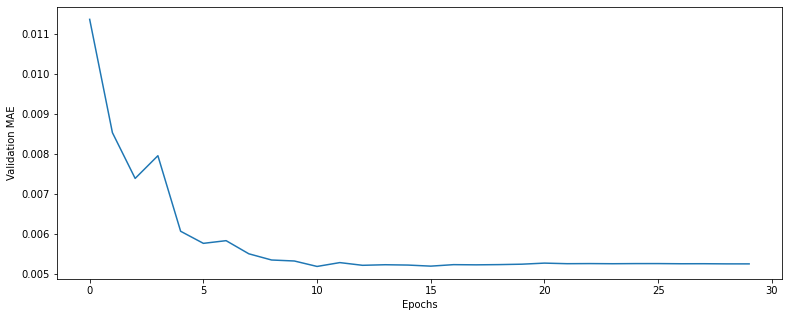

In [ ]:
import matplotlib.pyplot as plt

# Average all 
average_loss_history = [np.mean([x[i] for x in all_loss_history]) for i in range(num_epochs)]

plt.figure(figsize=(13,5))
plt.plot(range(len(average_loss_history)), average_loss_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()